# **CIRRHOSIS PATIENT SURVIVAL PREDICTION BY ISRAEL DUROTOYE**

# *Defining the Problem Statement*

Cirrhosis is a severe liver condition characterized by irreversible scarring of the liver tissue, often resulting from chronic liver diseases such as hepatitis and long-term alcohol abuse. The progression of cirrhosis can lead to life-threatening complications, including:

- **Portal Hypertension**: Increased blood pressure in the portal vein, which supplies blood to the liver.
- **Variceal Bleeding**: Rupture and bleeding of enlarged veins in the esophagus or stomach.
- **Liver Cancer**: Elevated risk of developing hepatocellular carcinoma.
- **Liver Failure**: Complete loss of liver function, necessitating liver transplantation.

# *Project Objective*

Given the severity and potential complications of cirrhosis, predicting patient survival is crucial for timely medical intervention and management. This project aims to develop a predictive model to estimate the survival rates of cirrhosis patients based on various clinical and demographic factors. By accurately predicting survival, healthcare providers can make informed decisions regarding treatment plans and prioritize patients for liver transplantation.

## *Import all Libraries*

In [49]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

## *A Wrangle Function for Data Preprocessing*

In [50]:
def wrangle():

    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive', force_remount = True)

    # Define the file path
    file_path = '/content/drive/My Drive/cirrhosis.csv'

    # Read the csv file
    data = pd.read_csv(file_path)

    # Suppress warnings
    warnings.filterwarnings('ignore')

    # Map the categorical values to numerical values for the target variable
    data['Status'] = data['Status'].map({'D': 0, 'C': 1, 'CL': 2})

    # Drop rows with missing values in the `Drug` column
    data = data.dropna(subset = ['Drug'])

    # Impute the missing values with mean results
    # Create an imputer object with a mean filling strategy
    imputer = SimpleImputer(strategy = 'mean')
    column_names = ['Cholesterol', 'Copper', 'Tryglicerides', 'Platelets']
    data[column_names] = imputer.fit_transform(data[column_names])

    if data.isnull().sum().sum() == 0:
        print('There are no missing values in the dataset')

    return data

### *Import the Dataset with the Wrangle Function*

In [51]:
data = wrangle()
data.head()

Mounted at /content/drive
There are no missing values in the dataset


,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,0,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,1,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,0,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,0,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,2,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


# *Understanding The Dataset*

The dataset contains information about patients with cirrhosis, including various clinical and demographic factors. Below is a detailed explanation of each column in the dataset:

1. **ID**: Unique identifier for each patient.
2. **N_Days**: Number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986.
3. **Status**: Status of the patient:
    - **C**: Censored
    - **CL**: Censored due to liver transplantation
    - **D**: Death
4. **Drug**: Type of drug administered:
    - **D-penicillamine**
    - **Placebo**
5. **Age**: Age of the patient in days.
6. **Sex**: Gender of the patient:
    - **M**: Male
    - **F**: Female
7. **Ascites**: Presence of ascites (accumulation of fluid in the peritoneal cavity):
    - **N**: No
    - **Y**: Yes
8. **Hepatomegaly**: Presence of hepatomegaly (enlarged liver):
    - **N**: No
    - **Y**: Yes
9. **Spiders**: Presence of spider angiomata (small, spider-like blood vessels visible under the skin):
    - **N**: No
    - **Y**: Yes
10. **Edema**: Presence of edema (swelling caused by fluid retention):
     - **N**: No edema and no diuretic therapy for edema
     - **S**: Edema present without diuretics, or edema resolved by diuretics
     - **Y**: Edema despite diuretic therapy
11. **Bilirubin**: Serum bilirubin level in mg/dl.
12. **Cholesterol**: Serum cholesterol level in mg/dl.
13. **Albumin**: Albumin level in gm/dl.
14. **Copper**: Urine copper level in ug/day.
15. **Alk_Phos**: Alkaline phosphatase level in U/ml.
16. **SGOT**: Serum glutamic-oxaloacetic transaminase (SGOT) level in U/ml.
17. **Triglycerides**: Triglycerides level in mg/dl.
18. **Platelets**: Platelet count per cubic ml/1000.
19. **Prothrombin**: Prothrombin time in seconds.
20. **Stage**: Histologic stage of the disease (1, 2, 3, or 4).

## *Split the Dataset and Encode Categorical Values*

In [52]:
# Split the data into X and y
X = data.drop(columns = ['Status'])
y = data['Status']

# Apply one-hot encoding to categorical features in X
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
numerical_features_1 = ['Bilirubin', 'Albumin', 'Cholesterol', 'Copper', 'Prothrombin', 'Age']
numerical_features_2 = ['Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'N_Days']
encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
scaler_1 = MinMaxScaler()
scaler_2 = StandardScaler()

transformer = ColumnTransformer([('categorical', encoder, categorical_features),
                                 ('numerical_1', scaler_1, numerical_features_1),
                                 ('numerical_2', scaler_2, numerical_features_2)],
                                 remainder = 'passthrough')
X = transformer.fit_transform(X)
X = pd.DataFrame(X)

X.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.260274,0.395062,0.622822,-0.123847,0.271931,0.764998,-0.758492,-1.432360,1.0,4.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.085616,0.197531,0.578364,2.532642,-0.159629,-0.593622,-0.431624,2.223526,2.0,3.0
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.352740,0.370370,0.839597,-0.686329,-0.467356,-1.127366,-1.169713,-0.886652,3.0,4.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.102740,0.160494,0.545664,1.936935,-1.093939,-0.528926,-0.832301,-0.072549,4.0,4.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.238014,0.234568,0.226748,-0.613796,-0.166165,-0.852407,-1.327875,-0.447946,5.0,3.0


### *Split the Dataset into Train and Test Sets*

In [53]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 42,
                                                    shuffle = True)

# **Model Training**

## *Models to be Used for Training*

In this project, I will use the following machine learning models to train the data and predict the survival status of cirrhosis patients:

1. **Logistic Regression**:
    - **Reason**: Logistic Regression is a simple yet effective linear model for binary classification problems. It predicts the probability of the target variable belonging to a particular class and is useful for understanding the relationship between the features and the target variable.

2. **Random Forest Classifier**:
    - **Reason**: Random Forest is an ensemble learning method that constructs multiple decision trees and merges them to get a more accurate and stable prediction. It is robust to overfitting and can handle a large number of features and complex interactions between them.

3. **Support Vector Machine (SVM)**:
    - **Reason**: SVM is a powerful supervised learning model that can be used for both classification and regression tasks. It works well with high-dimensional data and is effective in cases where the number of dimensions exceeds the number of samples.

4. **CatBoost Classifier**:
    - **Reason**: CatBoost is a gradient boosting algorithm that handles categorical features automatically. It is known for its high performance and efficiency, especially with datasets that have a mix of numerical and categorical features.

By using a combination of these models, I aim to leverage their individual strengths and compare their performance to identify the best model for predicting the survival status of cirrhosis patients.

In [54]:
# 1. Logistic Regression
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))

# 2. Random Forest
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# 3. Support Vector Machine
svm_clf = SVC(kernel = 'linear')
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


# 4. CatBoost Classifier
catboost_clf = CatBoostClassifier(iterations = 1000, learning_rate = 0.1, depth = 6, verbose = 0)
catboost_clf.fit(X_train, y_train)
y_pred_catboost = catboost_clf.predict(X_test)
print("CatBoost Classifier Accuracy:", accuracy_score(y_test, y_pred_catboost))
print("CatBoost Classifier Classification Report:\n", classification_report(y_test, y_pred_catboost))

Logistic Regression Accuracy: 0.8095238095238095
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89        26
           1       0.76      0.90      0.83        29
           2       1.00      0.12      0.22         8

    accuracy                           0.81        63
   macro avg       0.87      0.65      0.65        63
weighted avg       0.83      0.81      0.78        63

Random Forest Accuracy: 0.7142857142857143
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75        26
           1       0.68      0.90      0.78        29
           2       0.00      0.00      0.00         8

    accuracy                           0.71        63
   macro avg       0.48      0.54      0.51        63
weighted avg       0.63      0.71      0.66        63

SVM Accuracy: 0.8412698412698413
SVM Classification Report:
    

# **Model Evaluation**

## *Model Comparison*

In this project, I evaluated the performance of several machine learning models to predict the survival status of cirrhosis patients. The models used include Logistic Regression, Random Forest, Support Vector Machine (SVM), CatBoost, and Decision Tree. Below is a brief comparison of their performance based on accuracy and F1-score:

1. **Logistic Regression**:
    - **Accuracy**: 80.95%
    - **F1-Score**: 77.50% (weighted average)

2. **Random Forest**:
    - **Accuracy**: 71.43%
    - **F1-Score**: 66.48% (weighted average)

3. **Support Vector Machine (SVM)**:
    - **Accuracy**: 84.13%
    - **F1-Score**: 81.86% (weighted average)

4. **CatBoost**:
    - **Accuracy**: 76.19%
    - **F1-Score**: 71.19% (weighted average)

5. **Decision Tree**:
    - **Accuracy**: 66.67%
    - **F1-Score**: 64.91% (weighted average)

From the comparison, I observe that the Support Vector Machine (SVM) model performs the best overall, with the highest accuracy and balanced F1-scores across the classes. Logistic Regression also performs well, especially in terms of precision and recall for Class 0 and Class 1. However, the performance for Class 2 is generally poor across all models, indicating a need for further investigation and potential model improvement for this class.

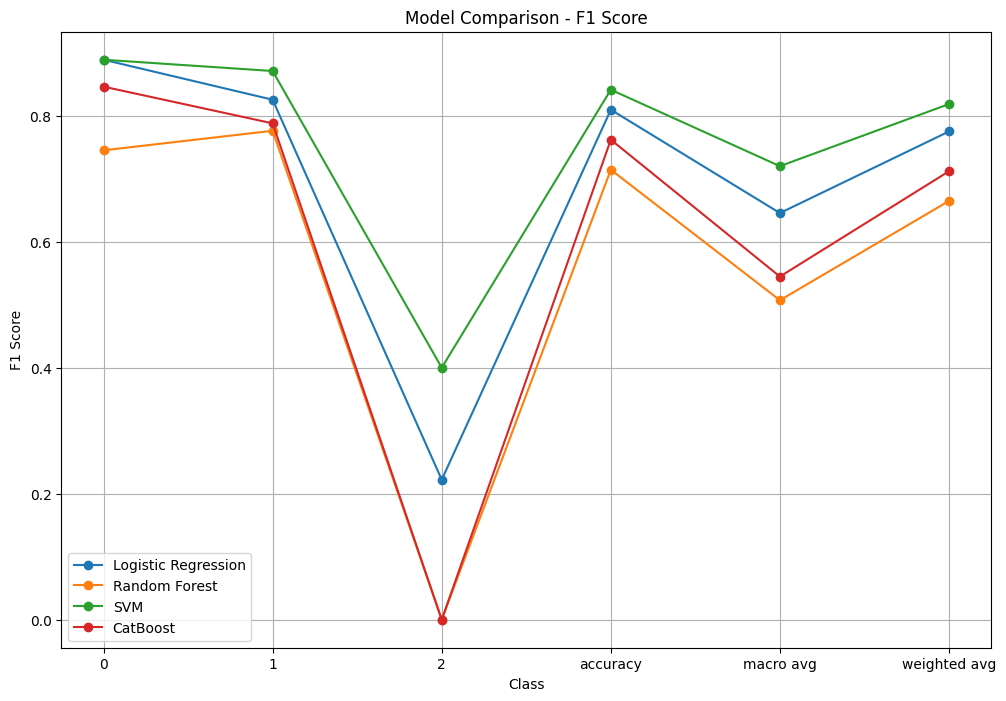

In [55]:
# Function to get classification report as a dataframe
def get_classification_report_df(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict = True)
    df = pd.DataFrame(report).transpose()
    df['model'] = model_name
    return df

# Get classification reports for each model
log_reg_report = get_classification_report_df(y_test, y_pred_log_reg, 'Logistic Regression')
rf_report = get_classification_report_df(y_test, y_pred_rf, 'Random Forest')
svm_report = get_classification_report_df(y_test, y_pred_svm, 'SVM')
catboost_report = get_classification_report_df(y_test, y_pred_catboost, 'CatBoost')

# Combine all reports into a single dataframe
all_reports = pd.concat([log_reg_report, rf_report, svm_report, catboost_report])

# Plot the comparison graph
plt.figure(figsize = (12, 8))
for model in all_reports['model'].unique():
    model_data = all_reports[all_reports['model'] == model]
    plt.plot(model_data.index, model_data['f1-score'], marker = 'o', label = model)

plt.title('Model Comparison - F1 Score')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
all_reports

,precision,recall,f1-score,support,model
0,0.857143,0.923077,0.888889,26.000000,Logistic Regression
1,0.764706,0.896552,0.825397,29.000000,Logistic Regression
2,1.000000,0.125000,0.222222,8.000000,Logistic Regression
accuracy,0.809524,0.809524,0.809524,0.809524,Logistic Regression
macro avg,0.873950,0.648210,0.645503,63.000000,Logistic Regression
weighted avg,0.832733,0.809524,0.775006,63.000000,Logistic Regression
0,0.760000,0.730769,0.745098,26.000000,Random Forest
1,0.684211,0.896552,0.776119,29.000000,Random Forest
2,0.000000,0.000000,0.000000,8.000000,Random Forest
accuracy,0.714286,0.714286,0.714286,0.714286,Random Forest


### *A Graph to Compare the Different Accuracies of the Trained Models*

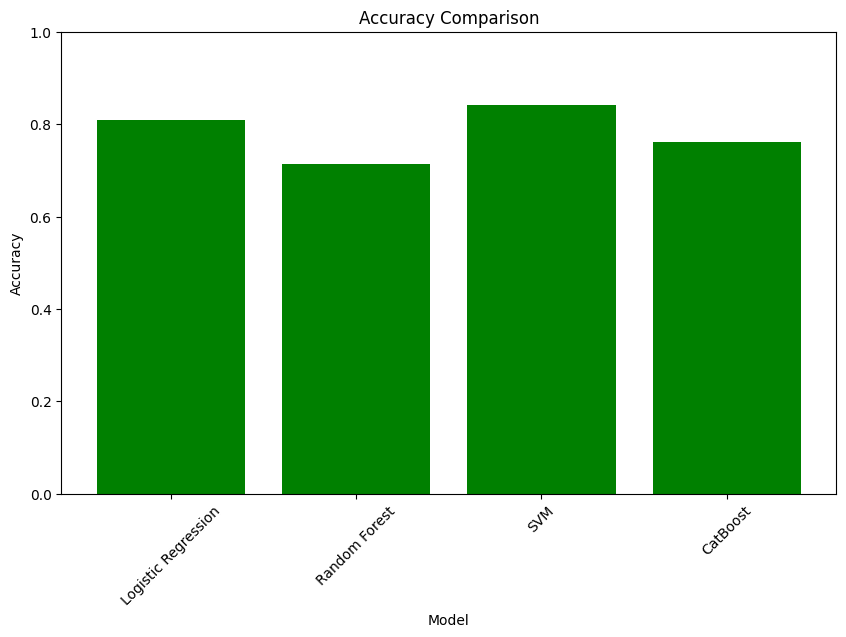

In [57]:
# Extract model names and their corresponding accuracies
model_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in model_names]

# Plot the graph
plt.figure(figsize = (10, 6))
plt.bar(model_names, accuracies, color='green')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

## *Confusion Matrix Visualization*

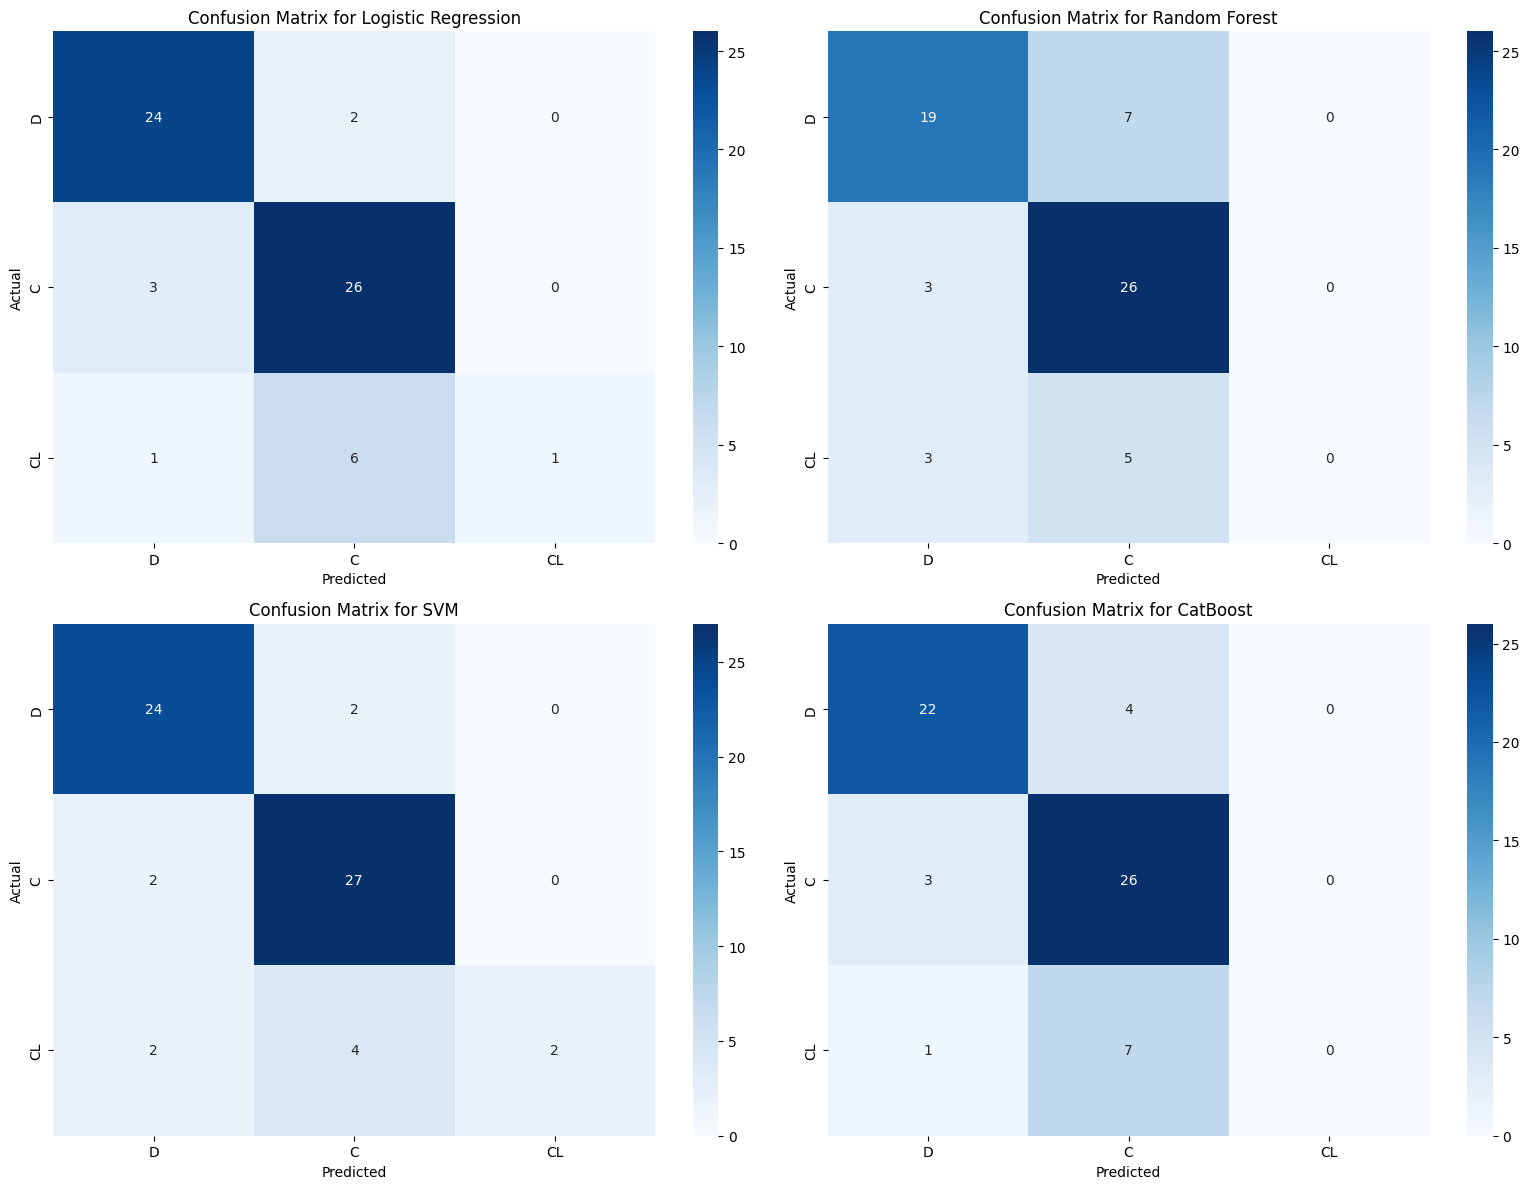

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['D', 'C', 'CL'], yticklabels=['D', 'C', 'CL'], ax=ax)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot confusion matrices for each model
plot_confusion_matrix(y_test, y_pred_log_reg, 'Logistic Regression', axes[0, 0])
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest', axes[0, 1])
plot_confusion_matrix(y_test, y_pred_svm, 'SVM', axes[1, 0])
plot_confusion_matrix(y_test, y_pred_catboost, 'CatBoost', axes[1, 1])

plt.tight_layout()
plt.show()

## Model Evaluation

In this section, I evaluate the performance of the various machine learning models used to predict the survival status of cirrhosis patients. The models evaluated include Logistic Regression, Random Forest, Support Vector Machine (SVM), and CatBoost. The evaluation metrics used are accuracy, precision, recall, and F1-score.

### Logistic Regression
Logistic Regression is a linear model used for binary classification. It predicts the probability of the target variable belonging to a particular class. The performance of the Logistic Regression model is as follows:
- **Accuracy**: 80.95%
- **Precision**: 85.71% (Class 0), 76.47% (Class 1), 100.00% (Class 2)
- **Recall**: 92.31% (Class 0), 89.66% (Class 1), 12.50% (Class 2)
- **F1-Score**: 88.89% (Class 0), 82.54% (Class 1), 22.22% (Class 2)

### Random Forest
Random Forest is an ensemble learning method that constructs multiple decision trees and merges them to get a more accurate and stable prediction. The performance of the Random Forest model is as follows:
- **Accuracy**: 71.43%
- **Precision**: 76.00% (Class 0), 68.42% (Class 1), 0.00% (Class 2)
- **Recall**: 73.08% (Class 0), 89.66% (Class 1), 0.00% (Class 2)
- **F1-Score**: 74.51% (Class 0), 77.61% (Class 1), 0.00% (Class 2)

### Support Vector Machine (SVM)
SVM is a supervised learning model that analyzes data for classification and regression analysis. The performance of the SVM model is as follows:
- **Accuracy**: 84.13%
- **Precision**: 85.71% (Class 0), 81.82% (Class 1), 100.00% (Class 2)
- **Recall**: 92.31% (Class 0), 93.10% (Class 1), 25.00% (Class 2)
- **F1-Score**: 88.89% (Class 0), 87.10% (Class 1), 40.00% (Class 2)

### CatBoost
CatBoost is a gradient boosting algorithm that handles categorical features automatically. The performance of the CatBoost model is as follows:
- **Accuracy**: 76.19%
- **Precision**: 84.62% (Class 0), 70.27% (Class 1), 0.00% (Class 2)
- **Recall**: 84.62% (Class 0), 89.66% (Class 1), 0.00% (Class 2)
- **F1-Score**: 84.62% (Class 0), 78.79% (Class 1), 0.00% (Class 2)


### Conclusion
From the evaluation metrics, I observe that the Support Vector Machine (SVM) model performs the best overall, with the highest accuracy and balanced precision, recall, and F1-scores across the classes. Logistic Regression also performs well, especially in terms of precision and recall for Class 0 and Class 1. However, the performance for Class 2 is generally poor across all models, indicating a need for further investigation and potential model improvement for this class.

## *Save the Model*

In [59]:
import joblib

# Save the SVM model to a file
joblib.dump(svm_clf, 'Cirrhosis_Patient_Survival_Model.pkl')

['Cirrhosis_Patient_Survival_Model.pkl']

## **ALL THE CODES IN ONE CELL**

In [60]:
from sklearn.pipeline import Pipeline

def preprocess_and_train():

    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive', force_remount = True)

    # Define the file path
    file_path = '/content/drive/My Drive/cirrhosis.csv'

    # Read the csv file
    data = pd.read_csv(file_path)

    # Suppress warnings
    warnings.filterwarnings('ignore')

    # Map the categorical values to numerical values
    data['Status'] = data['Status'].map({'D': 0, 'C': 1, 'CL': 2})

    # Drop rows with missing values in the `Drug` column
    data = data.dropna(subset=['Drug'])

    # Define the preprocessing pipeline
    categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
    numerical_features_1 = ['Bilirubin', 'Albumin', 'Cholesterol', 'Copper', 'Prothrombin', 'Age']
    numerical_features_2 = ['Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'N_Days']

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    numerical_transformer_1 = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ])

    numerical_transformer_2 = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num1', numerical_transformer_1, numerical_features_1),
            ('num2', numerical_transformer_2, numerical_features_2)
        ],
        remainder='passthrough'
    )

    # Split the data into X and y
    X = data.drop(columns=['Status'])
    y = data['Status']

    # Apply the preprocessing pipeline
    X = preprocessor.fit_transform(X)
    X = pd.DataFrame(X)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    # Train and evaluate models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='linear'),
        'CatBoost': CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0),
    }

    results = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[model_name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }

    return results

# Calling the Function
results = preprocess_and_train()
for model_name, result in results.items():
    print(f"{model_name} Accuracy: {result['accuracy']}")
    print(f"{model_name} Classification Report:\n", pd.DataFrame(result['classification_report']).transpose())

Mounted at /content/drive
Logistic Regression Accuracy: 0.8095238095238095
Logistic Regression Classification Report:
               precision    recall  f1-score    support
0              0.857143  0.923077  0.888889  26.000000
1              0.764706  0.896552  0.825397  29.000000
2              1.000000  0.125000  0.222222   8.000000
accuracy       0.809524  0.809524  0.809524   0.809524
macro avg      0.873950  0.648210  0.645503  63.000000
weighted avg   0.832733  0.809524  0.775006  63.000000
Random Forest Accuracy: 0.7142857142857143
Random Forest Classification Report:
               precision    recall  f1-score    support
0              0.760000  0.730769  0.745098  26.000000
1              0.684211  0.896552  0.776119  29.000000
2              0.000000  0.000000  0.000000   8.000000
accuracy       0.714286  0.714286  0.714286   0.714286
macro avg      0.481404  0.542440  0.507072  63.000000
weighted avg   0.628605  0.714286  0.664762  63.000000
SVM Accuracy: 0.84126984126984